# Getting Started with PyTorch Image Models (timm): a practitioner's guide

The purpose of this notebook is to explore timm from a practitioner's point of view, focusing on how to use some of the features and components included in timm in custom training scripts. The focus is not to explore how or why these concepts work, or how they are implemented in timm; for this, links to the original papers will be provided where appropriate, and I would recommend timmdocs to learn more about timm's internals.

At the time of writing, the latest version of timm is `timm==0.5.4`

### Table of Contents

- [Models](#models)
 - [General Usage](#general-usage)
 - [Customizing Models](#customizing-models)
 - [Feature Extraction](#feature-extraction)
 - [Exporting to other formats](#exporting)
- [Data Augmentation](data-augmentation)
 - [RandAugment](#randaugment)
 - [CutMix and Mixup](#cutmix-mixup)
- [Datasets](#datasets)
 - [Using TorchVision Datasets](#datasets-torchvision)
 - [Using TensorFlow Datasets](#datasets-tf)
 - [Using Local Datasets](#datasets-local)
 - [The ImageDataset class](#imagedataset)
- [Optimizers](#optimizers)
 - [Usage Example](#optimizer-usage)
 - [Lookahead](#lookahead)
- [Schedulers](#schedulers)
 - [Usage Example](#scheduler-usage)
 - [Adjusting learning rate schedules](#lr-cycles)
- [Exponential Moving Average Model](#ema-model)
- [Putting it all together](#example)
  

In [1]:
import torch

import timm

## Download Data 

Before we begin, lets first download some popular datasets for demonstration purposes. Here, I'm using the Oxford-IIT Pet Dataset -  37 category pet dataset with roughly 200 images for each class- and Imagenette, a subset of 10 easily classified classes from Imagenet.

### Download Pets Dataset 

In [7]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -P pets

--2022-01-18 11:36:17--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘pets/images.tar.gz’

images.tar.gz       100%[===================>] 755.23M   112MB/s    in 6.8s    

2022-01-18 11:36:24 (111 MB/s) - ‘pets/images.tar.gz’ saved [791918971/791918971]



In [8]:
!tar zxf pets/images.tar.gz -C pets

In [10]:
!ls pets/images

Abyssinian_1.jpg		   english_cocker_spaniel_184.jpg
Abyssinian_10.jpg		   english_cocker_spaniel_185.jpg
Abyssinian_100.jpg		   english_cocker_spaniel_186.jpg
Abyssinian_100.mat		   english_cocker_spaniel_187.jpg
Abyssinian_101.jpg		   english_cocker_spaniel_188.jpg
Abyssinian_101.mat		   english_cocker_spaniel_189.jpg
Abyssinian_102.jpg		   english_cocker_spaniel_19.jpg
Abyssinian_102.mat		   english_cocker_spaniel_190.jpg
Abyssinian_103.jpg		   english_cocker_spaniel_191.jpg
Abyssinian_104.jpg		   english_cocker_spaniel_192.jpg
Abyssinian_105.jpg		   english_cocker_spaniel_193.jpg
Abyssinian_106.jpg		   english_cocker_spaniel_194.jpg
Abyssinian_107.jpg		   english_cocker_spaniel_195.jpg
Abyssinian_108.jpg		   english_cocker_spaniel_196.jpg
Abyssinian_109.jpg		   english_cocker_spaniel_197.jpg
Abyssinian_11.jpg		   english_cocker_spaniel_198.jpg
Abyssinian_110.jpg		   english_cocker_spaniel_199.jpg
Abyssinian_111.jpg		   english_cocker_spaniel_2.jpg
Abyssinian_112.jpg		   english_cock

In [22]:
pets_image_paths

[PosixPath('pets/images/chihuahua_154.jpg'),
 PosixPath('pets/images/english_cocker_spaniel_118.jpg'),
 PosixPath('pets/images/english_setter_8.jpg'),
 PosixPath('pets/images/yorkshire_terrier_140.jpg'),
 PosixPath('pets/images/beagle_90.jpg'),
 PosixPath('pets/images/Bombay_29.jpg'),
 PosixPath('pets/images/British_Shorthair_82.jpg'),
 PosixPath('pets/images/Persian_161.jpg'),
 PosixPath('pets/images/boxer_177.jpg'),
 PosixPath('pets/images/great_pyrenees_5.jpg'),
 PosixPath('pets/images/pomeranian_20.jpg'),
 PosixPath('pets/images/boxer_136.jpg'),
 PosixPath('pets/images/Bengal_186.jpg'),
 PosixPath('pets/images/yorkshire_terrier_183.jpg'),
 PosixPath('pets/images/japanese_chin_74.jpg'),
 PosixPath('pets/images/British_Shorthair_178.jpg'),
 PosixPath('pets/images/japanese_chin_175.jpg'),
 PosixPath('pets/images/american_bulldog_202.jpg'),
 PosixPath('pets/images/beagle_38.jpg'),
 PosixPath('pets/images/Abyssinian_70.jpg'),
 PosixPath('pets/images/British_Shorthair_203.jpg'),
 PosixPa

### Download Imagenette

In [14]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz -P imagenette

--2022-01-18 11:39:58--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.237.125
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.237.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: ‘imagenette/imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.83M  42.9MB/s    in 9.0s    

2022-01-18 11:40:07 (36.2 MB/s) - ‘imagenette/imagenette2-320.tgz’ saved [341663724/341663724]



In [15]:
!tar zxf imagenette/imagenette2-320.tgz -C imagenette

In [17]:
!gzip -d imagenette/imagenette2-320.tgz

In [18]:
!ls imagenette

imagenette2-320  imagenette2-320.tar


### Set Data Paths

In [2]:
from pathlib import Path

In [3]:
pets_path = Path('pets/images')
pets_image_paths = list(pets_path.iterdir())

# Models <a class="anchor" id="models"></a>

One of the most popular features of timm is its large, and ever-growing collection of model architectures. Many of these models contain pretrained weights - either trained natively in PyTorch, or ported from other libraries such as Jax and Tensorflow - which can be easily downloaded and used.

We can list, and query, the collection available models as demonstrated below:

In [4]:
len(timm.list_models('*'))

739

We can also use the `pretrained` argument to filter this selection to the models with pretrained weights:

In [5]:
len(timm.list_models(pretrained=True))

592

This is still an impressive number! If you are experiencing a little option paralysis at this point, don't despair! A helpful resource which can be used to explore some of the models available, and understand their performance, is [this summary page](https://paperswithcode.com/lib/timm) by [Papers with code](https://paperswithcode.com/), which contains benchmarks and links to the original papers for many of the models included in timm.

For simplicity, let's stick with the familiar, tried and tested, ResNet model family here. We can list the different ResNet variants available by providing a wildcard string, which will be used as a filter based on the model names:

In [6]:
timm.list_models('resnet*', pretrained=True)

['resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50d',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101d',
 'resnet152',
 'resnet152d',
 'resnet200d',
 'resnetblur50',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50x1_bit_distilled',
 'resnetv2_50x1_bitm',
 'resnetv2_50x1_bitm_in21k',
 'resnetv2_50x3_bitm',
 'resnetv2_50x3_bitm_in21k',
 'resnetv2_101',
 'resnetv2_101x1_bitm',
 'resnetv2_101x1_bitm_in21k',
 'resnetv2_101x3_bitm',
 'resnetv2_101x3_bitm_in21k',
 'resnetv2_152x2_bit_teacher',
 'resnetv2_152x2_bit_teacher_384',
 'resnetv2_152x2_bitm',
 'resnetv2_152x2_bitm_in21k',
 'resnetv2_152x4_bitm',
 'resnetv2_152x4_bitm_in21k']

As we can see, there are still a lot of options! Now, let's explore how we can create a model from this list.

## General Usage <a class="anchor" id="general-usage"></a>

The easiest way to create a model is by using `create_model`; a factory function that can be used to create any model in the timm library.

Let's demonstrate this by creating a `Resnet-D` model, as introduced in the `Bag of Tricks for Image Classification For Convolutional Neural Networks` paper; which is a modification on the ResNet architecture that utilises an average pooling tweak for downsampling. This was largely an arbitrary choice, and the features that are demonstrated here should work on the majority of models included in timm.

In [7]:
model = timm.create_model('resnet50d', pretrained=True)

In [8]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

As we can see, this is just a regular PyTorch model. 

To help us understand more about how to use this model, we can access its config, which contains information such as the statistics that should be used to normalise the input data, the number of output classes and the name of the classification portion of the network.

In [9]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1.0',
 'classifier': 'fc',
 'architecture': 'resnet50d'}

### Pretrained Models for images with varying numbers of input channels

One less well known, but incredibly useful, feature of timm models is that they are able to work on input images with varying numbers of channels, which pose a problem for most other libraries; an excellent explanation of how this works is described [here](https://fastai.github.io/timmdocs/models#So-how-is-timm-able-to-load-these-weights?). Intuitively, timm does this by summing the weights of the initial convolutional layer for channels fewer than 3, or intelligently replicating these weights to the desired number of channels otherwise.

We can specify the number of channels for our input images by passing the `in_chans` argument to `create_model`. 

In [10]:
m = timm.create_model('resnet50d', pretrained=True, in_chans=1)

# single channel image
x = torch.randn(1, 1, 224, 224)

m(x).shape

torch.Size([1, 1000])

Using a random tensor to represent a single channel image in this case, we can see that the model has processed the image and returned the expected output shape.

It is important to note that, whilst this has enabled us to use a pretrained model, the input is significantly different to the images that the model was trained on. Because of this, we should not expect the same level of performance, and finetune the model on the new dataset before using on the task!

## Customizing models <a class="anchor" id="customizing-models"></a>

In addition to creating models with stock architectures, `create_model` also supports a number of arguments enabling us to customise a model for our task.

The arguments that are supported can depend on the underlying model architecture, with some arguments such as:

- `global_pool`: determine the type of global pooling to be used before the final classification layers 

being model specific. In this case, it is dependent on whether the architecture employs a global pooling layer. Therefore, whilst we will be fine using this with a ResNet-like model, it wouldn't make sense to use it with [ViT](https://arxiv.org/abs/2010.11929v2), which doesn't use average pooling.

Whilst some arguments are model specific, arguments such as:

- `drop_rate`: set the dropout rate for training (Default: `0`)

- `num_classes`: the number of output neurons corresponding to classes

can be used for almost all models.

Before we explore some of the ways that we can do this, lets examine the default architecture of our current model.

### Changing the number of classes

Examining the model config that we saw earlier, we can see that the name of the classification head for our network is `fc`. We can use this to access the corresponding module directly.

In [11]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

However, this name is likely to change depending on the model architecture used. To provide a consistent interface for different models, timm models have the `get_classifier` method, which we can use to retrieve the classification head without having to lookup the module name.

In [12]:
model.get_classifier()

Linear(in_features=2048, out_features=1000, bias=True)

As expected, this returns the same linear layer as before.

As this model was pretrained on ImageNet, we can see that the final layer outputs 1000 classes. We can change this with the `num_classes` argument:

In [13]:
timm.create_model('resnet50d', pretrained=True, num_classes=10).get_classifier()

Linear(in_features=2048, out_features=10, bias=True)

Inspecting the classifier, we can see that timm has replaced the final layer with a new, untrained, linear layer with the desired number of classes; ready to finetune on our dataset!

If we would like to avoid creating the last layer completely, we can set the number of classes equal to `0`, which will create a model with the identity function as the final layer; this can be useful for inspecting the output of penultimate layer.

In [11]:
timm.create_model('resnet50d', pretrained=True, num_classes=0).get_classifier()

Identity()

### Global Pooling options

From our model's config, we can also see that the `pool_size` is set, informing us that a global pooling layer is used before the classifier. We can inspect this as follows:

In [12]:
model.global_pool

SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))

Here, we can see that this returns an instance of `SelectAdaptivePool2d`, which is a custom layer provided by timm, which supports different pooling and flattening configurations. At the time of writing, the supported pooling options are:
- `avg`: Average pooling
- `max`:  Max pooling
- `avgmax`: the sum of average and max pooling, re-scaled by 0.5
- `catavgmax`: a concatenation of the outputs of average and max pooling along feature dimension. Note that this will double the feature dimension.
- `''`: No pooling is used, the pooling layer is replaced by an Identity operation

We can visualise the output shapes of the different pooling options as demonstrated below

In [13]:
pool_types = ['avg', 'max', 'avgmax', 'catavgmax', '']

for pool in pool_types:
    model = timm.create_model('resnet50d', pretrained=True, num_classes=0, global_pool=pool)
    model.eval()
    feature_output = model(torch.randn(1, 3, 224, 224))
    print(feature_output.shape)
    

torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 4096])
torch.Size([1, 2048, 7, 7])


### Modifying an existing model

We can also modify the classifier and pooling layers of an existing model, using the `reset_classifier` method:

In [18]:
m = timm.create_model('resnet50d', pretrained=True)

print(f'Original pooling: {m.global_pool}')
print(f'Original classifier: {m.get_classifier()}')
print('--------------------')

m.reset_classifier(10, 'max')

print(f'Modified pooling: {m.global_pool}')
print(f'Modified classifier: {m.get_classifier()}')


Original pooling: SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Original classifier: Linear(in_features=2048, out_features=1000, bias=True)
--------------------
Modified pooling: SelectAdaptivePool2d (pool_type=max, flatten=Flatten(start_dim=1, end_dim=-1))
Modified classifier: Linear(in_features=2048, out_features=10, bias=True)


### Creating a new classification head

Whilst it has been demonstrated that using a single linear layer as our classifier is sufficient to achieve good results, when finetuning models on downstream tasks, I've often found that using a slightly larger head can lead to increased performance. Let's explore how we can modify our ResNet model further.

First, let's create our ResNet model as before, specifying that we would like 10 classes. As we are using a larger head, let's use `catavgmax` for our pooling, so that we provide more information as input to our classifier.

In [14]:
model = timm.create_model('resnet50d', pretrained=True, num_classes=10, global_pool='catavgmax')

In [15]:
from torch import nn

From the existing classifier, we can get the number of input features:

In [16]:
num_in_features = model.get_classifier().in_features; num_in_features

4096

Now, we can replace the final layer with our modified classification head by accessing the classifier directly. Here, the classfication head has been chosen somewhat arbitrarily.

In [22]:
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features=num_in_features, out_features=512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(in_features=512, out_features=10, bias=False))

Testing the model with a dummy input, we get an output of the expected shape. Now, our modified model is ready to train!

In [17]:
model.eval()
model(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 10])

## Feature Extraction <a class="anchor" id="feature-extraction"></a>

timm models also have consistent mechanisms for obtaining various types of intermediate features, which can be useful in order to use an architecture as a feature extractor for a downstream task; such as creating [feature pyramids in object detection](https://ieeexplore.ieee.org/document/8099589).

Let's visualise how this works by using an image from the [Oxford pets dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [25]:
from PIL import Image
import numpy as np

In [26]:
image = Image.open(pets_image_paths[1])

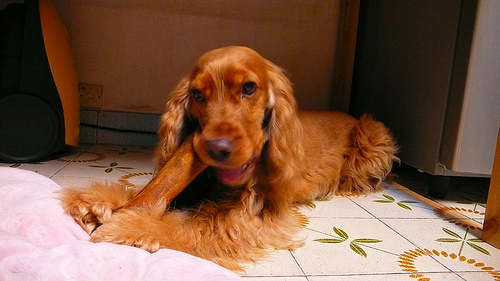

In [27]:
image

We can convert this into a tensor, and transpose the channels into the format that PyTorch expects:

In [28]:
image = torch.as_tensor(np.array(image, dtype=np.float32)).transpose(2, 0)[None]

Once again, let's create our ResNet-D model:

In [29]:
model = timm.create_model('resnet50d', pretrained=True)

In [30]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1.0',
 'classifier': 'fc',
 'architecture': 'resnet50d'}

If we are only interested in the final feature map - that is the output of the final convolutional layer prior to pooling in this case - we can use the `forward_features` method to bypass the global pooling and classification layers.

In [34]:
import matplotlib.pyplot as plt

In [31]:
feature_output = model.forward_features(image)

We can visualise this below:

In [35]:
def visualise_feature_output(t):
    plt.imshow(feature_output[0].transpose(0, 2).sum(-1).detach().numpy())
    plt.show()

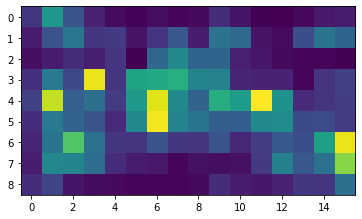

In [36]:
visualise_feature_output(feature_output)

### Multiple feature outputs

Whilst the forward features method can be convenient for retrieving the final feature map, timm also provides functionality which enables us to use models as feature backbones that output feature maps for selected levels.

We can specify that we would like to use a model as a feature backbone by using the argument `features_only=True` when creating a model. By default, 5 strides will be output from most models (not all have that many), with the first starting at 2 (some start at 1 or 4).

The indices of the feature levels, and number of strides can be modified using the `out_indices` and `output_stride` arguments, as [demonstrated in the docs](https://rwightman.github.io/pytorch-image-models/feature_extraction/#multi-scale-feature-maps-feature-pyramid)

Let's see how this works with our ResNet-D model.

In [3]:
model = timm.create_model('resnet50d', pretrained=True, features_only=True)

As demonstrated below, we can get more information about the features that are returned, such as the specific module names, the reduction in features and the number of channels:

In [38]:
model.feature_info.module_name()

['act1', 'layer1', 'layer2', 'layer3', 'layer4']

In [39]:
model.feature_info.reduction()

[2, 4, 8, 16, 32]

In [40]:
model.feature_info.channels()

[64, 256, 512, 1024, 2048]

Now, lets pass an image through our feature extractor and explore the output.

In [41]:
out = model(image)

In [42]:
len(out)

5

As expected, 5 feature maps have been returned. Inspecting the shape, we can see that the number of channels is consistent with what we expect:

In [43]:
for o in out:
    print(o.shape)

torch.Size([1, 64, 250, 141])
torch.Size([1, 256, 125, 71])
torch.Size([1, 512, 63, 36])
torch.Size([1, 1024, 32, 18])
torch.Size([1, 2048, 16, 9])


Visualising each feature map, we can see that the image is gradually downsampled, as we would expect.

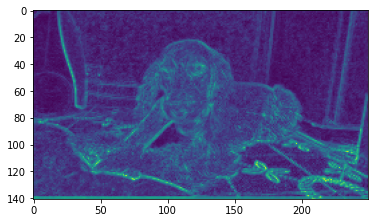

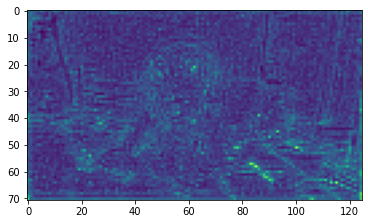

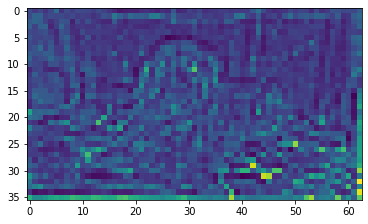

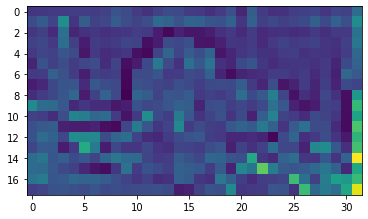

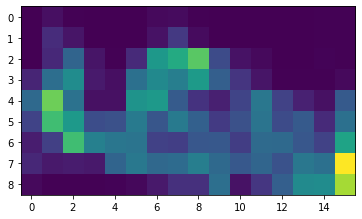

In [44]:
for o in out:
    plt.imshow(o[0].transpose(0, 2).sum(-1).detach().numpy())
    plt.show()

### Using FX

[TorchVision](https://pytorch.org/vision/stable/index.html) recently released a new utility called FX, which makes it easier to access intermediate transformations of an input during the forward pass of a PyTorch Module. This is done by symbolically tracing the forward method to produce a graph where each node represents a single operation. As nodes are given human-readable names, it is easy specify exactly which nodes we want to access. FX is described in more detail [in the docs](https://pytorch.org/docs/stable/fx.html#module-torch.fx) and in [this blog post](https://pytorch.org/blog/FX-feature-extraction-torchvision/).

**Note**: At the time of writing, dynamic control flow can’t yet be represented in terms of a static graph when using FX.

As almost all models in timm are symbolically traceable, we can use FX to manipulate these. Let's explore how we can use FX to extract features from timm models.

First, let's import some helper methods from TorchVision:

In [45]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

Now, we recreate our ResNet-D model, with a classification head, and use the `exportable` argument to ensure that the model is traceable.

In [4]:
model = timm.create_model('resnet50d', pretrained=True, exportable=True)

Now, we can use the `get_graph_node_names` method to return the node names in order of execution. As the model is traced twice, in train and eval modes, both sets of node names are returned.

In [47]:
nodes, _ = get_graph_node_names(model)

In [48]:
nodes

['x',
 'conv1.0',
 'conv1.1',
 'conv1.2',
 'conv1.3',
 'conv1.4',
 'conv1.5',
 'conv1.6',
 'bn1',
 'act1',
 'maxpool.0',
 'maxpool.1',
 'maxpool.2',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.act1',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.act2',
 'layer1.0.conv3',
 'layer1.0.bn3',
 'layer1.0.se.mean',
 'layer1.0.se.fc1',
 'layer1.0.se.bn',
 'layer1.0.se.act',
 'layer1.0.se.fc2',
 'layer1.0.se.gate.sigmoid',
 'layer1.0.se.mul',
 'layer1.0.downsample.0',
 'layer1.0.downsample.1',
 'layer1.0.downsample.2',
 'layer1.0.add',
 'layer1.0.act3',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.act1',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.act2',
 'layer1.1.conv3',
 'layer1.1.bn3',
 'layer1.1.se.mean',
 'layer1.1.se.fc1',
 'layer1.1.se.bn',
 'layer1.1.se.act',
 'layer1.1.se.fc2',
 'layer1.1.se.gate.sigmoid',
 'layer1.1.se.mul',
 'layer1.1.add',
 'layer1.1.act3',
 'layer1.2.conv1',
 'layer1.2.bn1',
 'layer1.2.act1',
 'layer1.2.conv2',
 'layer1.2.bn2',
 'layer1.2.act2',
 'layer1.

Using FX, can use easily access the output from any node. Let's select the second activation in `layer1`.

In [49]:
features = {'layer1.0.act2': 'out'}

Using `create_feature_extractor`, we can 'cut' the model at that point, as we can see below:

In [50]:
feature_extractor = create_feature_extractor(model, return_nodes=features)

In [51]:
feature_extractor

ResNet(
  (conv1): Module(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): Module(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): B

Now, passing an image through our feature extractor this will return a dict of Tensors. We can then visualise this as before: 

In [52]:
out = feature_extractor(image)

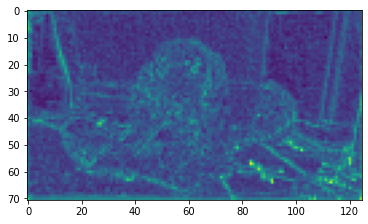

In [53]:
plt.imshow(out['out'][0].transpose(0, 2).sum(-1).detach().numpy())

## Exporting to different formats <a class="anchor" id="exporting"></a>

After training, it is often recommended to export your models to an optimized format for inference; PyTorch has multiple options for doing this. As almost all timm models are scriptable and traceable, we can make use of these formats.

Let's examine some of the options available.

### Exporting to TorchScript

TorchScript is a way to create serializable and optimizable models from PyTorch code; any TorchScript program can be saved from a Python process and loaded in a process where there is no Python dependency. 

We can convert a model to TorchScript in two different ways:

- *Tracing*: runs the code, records the operations that happen and constructs a ScriptModule containing those operations. Control flow, or dynamic behaviour such as if/else statements are erased.
- *Scripting*: uses a script compiler to perform a direct analysis of your Python source code to transform it into TorchScript. This preserves dynamic control flow and is valid for inputs of different sizes.

More about TorchScript can be seen [in the docs](https://pytorch.org/docs/stable/jit.html) and [in this tutorial](https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html)

As most timm models are scriptable, let's use scripting to export our ResNet-D model. We can set layer config so that model is jit scriptable using the `scriptable` argument when creating our model.

In [18]:
model = timm.create_model('resnet50d', pretrained=True, scriptable=True)
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

It is important to call `model.eval()` before exporting the model, to put the model into inference mode, as operators such as dropout and batchnorm behave differently depending on the mode.

We can now verify that we are able to script and use our model.

In [56]:
scripted_model = torch.jit.script(model)

In [57]:
scripted_model

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Conv2d)
  )
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (act1): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Bottleneck
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (act1): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule

In [58]:
scripted_model(torch.rand(8, 3, 224, 224)).shape

torch.Size([8, 1000])

### Exporting to ONNX

[Open Neural Network eXchange (ONNX)](https://onnx.ai/) is an open standard format for representing machine learning models. 

We can use the `torch.onnx` module to export timm models to ONNX; enabling them to be consumed by any of the many runtimes that support ONNX. If `torch.onnx.export()` is called with a Module that is not already a ScriptModule, it first does the equivalent of torch.jit.trace(), which executes the model once with the given args and records all operations that happen during that execution. This means that if the model is dynamic, e.g., changes behaviour depending on input data, the exported model will not capture this dynamic behaviour. Similarly, a trace is likely to be valid only for a specific input size.

More details on ONNX can be found in [the docs](https://pytorch.org/docs/master/onnx.html).

To enable exporting a timm model in ONNX format, we can use the `exportable` argument when creating the model, to ensure that the model is traceable.

In [5]:
model = timm.create_model('resnet50d', pretrained=True, exportable=True)
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

We can now use `torch.onnx.export` to trace and export our model:

In [60]:
x = torch.randn(2, 3, 224, 224, requires_grad=True)
torch_out = model(x)

# Export the model
torch.onnx.export(model,                                       # model being run
                  x,                                           # model input (or a tuple for multiple inputs)
                  "resnet50d.onnx",                            # where to save the model (can be a file or file-like object)
                  export_params=True,                          # store the trained parameter weights inside the model file
                  opset_version=10,                            # the ONNX version to export the model to
                  do_constant_folding=True,                    # whether to execute constant folding for optimization
                  input_names = ['input'],                     # the model's input names
                  output_names = ['output'],                   # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},  # variable length axes
                                'output': {0 : 'batch_size'}})

We can now verify that our model is valid using the `check_model` function.

In [61]:
import onnx

onnx_model = onnx.load("resnet50d.onnx")
onnx.checker.check_model(onnx_model)

As we specified that our model should be traceable, we could also have performed the tracing manually as demonstrated below.

In [62]:
traced_model = torch.jit.trace(model, torch.rand(8, 3, 224, 224))

In [63]:
type(traced_model)

torch.jit._trace.TopLevelTracedModule

In [64]:
traced_model(torch.rand(8, 3, 224, 224)).shape

torch.Size([8, 1000])

## Data Augmentation <a class="anchor" id="data-augmentation"></a>

In [65]:
from PIL import Image

timm includes lots of data augmentation transforms, which can be chained together to make augmentation pipelines; similarly to TorchVision, these pipelines expect a PIL image as an input. 

The easiest way to get started is by using the `create_transform` factory function, let's explore how we can use this below.

In [19]:
from timm.data.transforms_factory import create_transform 

In [20]:
create_transform(224,)

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [21]:
create_transform(224, is_training=True)

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Here, we can see that this has created some basic augmentation pipeline including resizing, normalization and converting an image to a tensor. As we would expect, we can see that additional transformations, such as horizontal flipping and colour jitter, are included when we set `is_training=True`. The magnitude of these augmentations can be controlled with arguments such as ` hflip`, `vflip` and `color_jitter`.

We can also see that the method used to resize the image also varies depending on whether we are training. Whilst a standard `Resize` and `CenterCrop` are used during validation, during training, `RandomResizedCropAndInterpolation` is used, let's see what it does below. The implementation of this transform in timm also enables us to set different methods of image interpolation; here we are selecting that the interpolation is selected at random.

In [66]:
image = Image.open(pets_image_paths[0])

In [70]:
from timm.data.transforms import RandomResizedCropAndInterpolation

tfm = RandomResizedCropAndInterpolation(size=350, interpolation='random')

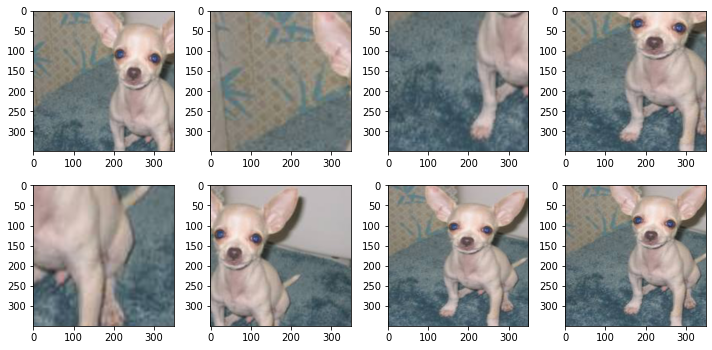

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(10, 5))

for idx, im in enumerate([tfm(image) for i in range(4)]):
    ax[0, idx].imshow(im)
    
for idx, im in enumerate([tfm(image) for i in range(4)]):
    ax[1, idx].imshow(im)

fig.tight_layout()
plt.show()

Running the transformation several times, we can observe that different crops have been taken of the image. Whilst this is beneficial during training, this may make the task harder during evaluation. Depending on the type of image, this type of transform may result in the subject of the picture being cropped out of the image; we can see an example of this if we look at the second image in the first row! Whilst this shouldn't be a huge problem if it occurs infrequently, we can avoid this by adjusting the scale parameter:

In [72]:
tfm = RandomResizedCropAndInterpolation(size=224, scale=(0.8, 1))

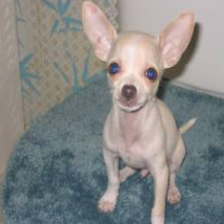

In [73]:
tfm(image)

### RandAugment <a class="anchor" id="randaugment"></a>

When starting a new task, it can be difficult to know which augmentations to use, and in which order; with the amount of augmentations now available, the number of combinations is huge! 

Often, a good place to start is by using an augmentation pipeline which has demonstrated good performance on other tasks. One such policy is RandAugment, is automated data augmentation method that uniformly samples operations from a set of augmentations - such as equalization, rotation, solarization, color jittering, posterizing, changing contrast, changing brightness, changing sharpness, shearing, and translations - and applies a number of these sequentially; for more info, see [the original paper] (https://arxiv.org/abs/1909.13719).

However, there are several key differences in the implementation provided in timm, which are best described by timm's creator Ross Wightman in the appendix of [the ResNets Strike Back paper](https://arxiv.org/pdf/2110.00476v1.pdf), which I paraphrase below: 

```
The original RandAugment specification has two hyper-parameters, M and N; where M is the distortion magnitude and N is the number of distortions uniformly sampled and applied per-image. The goal of RandAugment was that both M and N be human interpretable. 

However, that ended up not being the case for M [in the original implementation]. The scales of several augmentations were backwards or not monotonically increasing over the range such that increasing M does not increase the strength of all augmentations. [In the original implementation, whilst some augmentations go up in strength as M increases, others decrease or are removed entirely, such that each M essentially represents its own policy.] 

The implementation in timm attempts to improve this situation by adding an ‘increasing’ mode [enabled by default] where all augmentation strengths increase with magnitude. [This makes increasing M more intuitive, as all augmentations should now decrease/increase in strength with corresponding decrease/increase in M.]

[Additionally,] timm adds a MSTD parameter, which adds gaussian noise with the specified standard deviation to the M value per distortion application. If MSTD is set to ‘-inf’, M is uniformly sampled from 0-M for each distortion. 

Care was taken in timm’s RandAugment to reduce impact on image mean, the normalization parameters can be passed as a parameter such that all augmentations that may introduce border pixels can use the specified mean instead of defaulting to 0 or a hard-coded tuple as in other implementations. 

[Lastly,] Cutout is excluded by default to favour separate use of timm’s Random Erasing implementation* which has less
impact on mean and standard deviation of the augmented images.

```

 
*The implementation of Random Erasing in timm is explored in detail [here](https://fastai.github.io/timmdocs/RandomErase)

Now that we understand what RandAugment is, let's see how we can use it in an augmentation pipeline!

In timm, we define the parameters of our RandAugment policy by using a config string; which consists of multiple sections separated by dashes (`-`). 

The first section defines the specific variant of rand augment (currently only `rand` is supported). The remaining sections, which can be placed in any order, are:

- **m** (*integer*): the magnitude of rand augment
- **n** (*integer*): the number of transform ops selected per image, this is optional with default = 2
- **mstd** (*float*): the standard deviation of the magnitude noise applied
- **mmax** (*integer*): sets the upper bound for magnitude to something other than the default of 10
- **w** (*integer*): the probability weight index (index of a set of weights to influence the choice of operation)
- **inc** (*bool - {0, 1}*): use augmentations that increase in severity with magnitude, this is optional with default = 0
   
    
For example:
- *'rand-m9-n3-mstd0.5'*: results in RandAugment with magnitude 9, 3 augmentations per image, magnitude_std 0.5
- *'rand-mstd1-w0'*: results in magnitude_std 1.0, weights 0, default magnitude *m* of 10, and 2 augmentations per image


Passing a config string to `create_transform`, we can see that this is handled by the `RandAugment` object, and we can see the names of all available ops:

In [74]:
create_transform(224, is_training=True, auto_augment='rand-m9-mstd0.5')

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandAugment(n=2, ops=
	AugmentOp(name=AutoContrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Equalize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Invert, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Rotate, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Posterize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Solarize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=SolarizeAdd, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Color, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Contrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Brightness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Sharpness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearX, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearY, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateXRel, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateYRel, p=0.5, m=9, mstd=0.5))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.

We can also create this object for use in a custom pipeline by using the `rand_augment_transform` function, as demonstrated below:

In [75]:
from timm.data.auto_augment import rand_augment_transform

In [77]:
tfm = rand_augment_transform(
    config_str='rand-m9-mstd0.5', 
    hparams={'img_mean': (124, 116, 104)}
)

In [78]:
tfm

RandAugment(n=2, ops=
	AugmentOp(name=AutoContrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Equalize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Invert, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Rotate, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Posterize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Solarize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=SolarizeAdd, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Color, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Contrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Brightness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Sharpness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearX, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearY, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateXRel, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateYRel, p=0.5, m=9, mstd=0.5))

Let's apply this policy to an image to visualise some of the transformations.

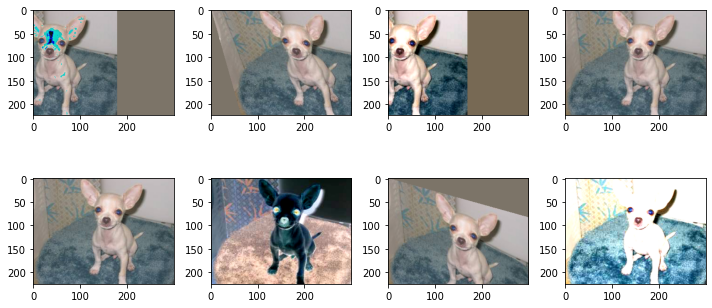

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(10, 5))

for idx, im in enumerate([tfm(image) for i in range(4)]):
    ax[0, idx].imshow(im)
    
for idx, im in enumerate([tfm(image) for i in range(4)]):
    ax[1, idx].imshow(im)

fig.tight_layout()
plt.show()

From this, we can see that using RandAugment has given us lots of variations of our image!

### CutMix and Mixup <a class="anchor" id="cutmix-mixup"></a>

timm provides a flexible implementation of the [CutMix](https://arxiv.org/abs/1905.04899) and [Mixup](https://arxiv.org/abs/1710.09412) augmentations, using the `Mixup` class; which handles both augmentations and provides the option of switching between them.

Using `Mixup`, we can select from variety of different mixing strategies:

- `batch`: CutMix vs Mixup selection, lambda, and CutMix region sampling are performed per batch
- `pair`: mixing, lambda, and region sampling are performed on sampled pairs within a batch
- `elem`: mixing, lambda, and region sampling are performed per image within batch
- `half`: the same as elementwise but one of each mixing pair is discarded so that each sample is seen once per epoch

Let's visualise how this works. To do this, we will need to create a DataLoader, iterate through it and apply the augmentations to the batch. Here, we shall use images from the Pets dataset.

In [23]:
from timm.data import ImageDataset
from torch.utils.data import DataLoader

def create_dataloader_iterator():
    dataset = ImageDataset('pets/images', transform=create_transform(224))
    dl = iter(DataLoader(dataset, batch_size=2))
    return dl
    

In [24]:
dataloader = create_dataloader_iterator()

In [25]:
inputs, classes = next(dataloader)

So that we can see the images, let's define a function to display tensors. Here, the implementation is taken from [timmdocs](https://fastai.github.io/timmdocs/mixup_cutmix)

In [26]:
# Taken from timmdocs https://fastai.github.io/timmdocs/mixup_cutmix

import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Using a helper function from torchvision, we can visualise the images in our batch with no augmentation applied:

In [27]:
import torchvision

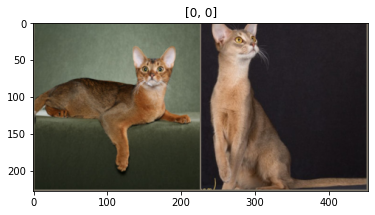

In [28]:
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

Now, let's create our MixUp transform!

`Mixup` supports the following arguments:

- `mixup_alpha` (_float_): mixup alpha value, mixup is active if > 0., (default: 1)
- `cutmix_alpha` (_float_): cutmix alpha value, cutmix is active if > 0. (default: 0)
- `cutmix_minmax` (_List[float]_): cutmix min/max image ratio, cutmix is active and uses this vs alpha if not None.
- `prob` (_float_): the probability of applying mixup or cutmix per batch or element (default: 1)
- `switch_prob` (_float_): the probability of switching to cutmix instead of mixup when both are active (default: 0.5)
- `mode` (_str_): how to apply mixup/cutmix params (default: `batch`)
- `label_smoothing` (_float_): the amount of label smoothing to apply to the mixed target tensor (default: 0.1)
- `num_classes` (_int_): the number of classes for the target variable

Let's define a set of arguments so that we apply either mixup or cutmix to a batch of images, and alternate with the probability of 1, and use these to create our `Mixup` transformation:

In [29]:
from timm.data.mixup import Mixup

mixup_args = {
    'mixup_alpha': 1.,
    'cutmix_alpha': 1.,
    'prob': 1,
    'switch_prob': 0.5,
    'mode': 'batch',
    'label_smoothing': 0.1,
    'num_classes': 2}

mixup_fn = Mixup(**mixup_args)

As mixup and cutmix take place on a batch of images, we can place the batch on the GPU before we apply the augmentation to speed things up! Here, we can see that mixup has been applied to this batch of images.

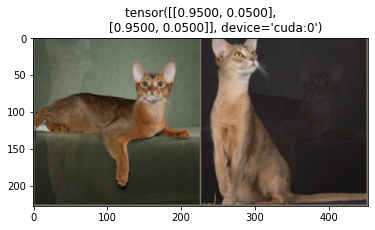

In [90]:
mixed_inputs, mixed_classes = mixup_fn(inputs.to(torch.device('cuda:0')), classes.to(torch.device('cuda:0')))
out = torchvision.utils.make_grid(mixed_inputs)
imshow(out, title=mixed_classes)

Running the augmentation again, we can see that, this time, CutMix has been applied.

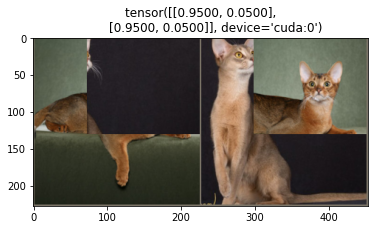

In [30]:
mixed_inputs, mixed_classes = mixup_fn(inputs.to(torch.device('cuda:0')), classes.to(torch.device('cuda:0')))
out = torchvision.utils.make_grid(mixed_inputs)
imshow(out, title=mixed_classes)

From the labels printed above each other, we can observe that we can also use Mixup for label smoothing!

## Datasets <a class="anchor" id="datasets"></a>

timm provides a number of useful utilities for working with different types of datasets. The easiest way to get started is using the `create_dataset` function, which will create an appropriate dataset for us.

`create_dataset` always expects two arguments:
- `name`: the name of the dataset that we want to load
- `root`: the root folder of the dataset on the local file system

but has additional keyword arguments that can be used to specify options such as whether we would like to load the training or validation set.

We can also use `create_dataset`to load data from several different places:

- datasets available in [TorchVision](https://pytorch.org/vision/0.11/datasets.html)
- datasets available in [TensorFlow datasets](https://www.tensorflow.org/datasets)
- datasets stored in local folders

Let's explore some of these options.

In [93]:
from timm.data import create_dataset

### Loading datasets from TorchVision <a class="anchor" id="datasets-torchvision"></a>

To load a dataset included with TorchVision, we simply specify the prefix `torch/` before the name of the dataset that we wish to load. If the data doesn't exist on the file system, we can download this data by setting `download=True`. Additionally, here we are specifying that we would like to load the training dataset with the `split` argument.

In [94]:
ds = create_dataset('torch/cifar10', 'cifar10', download=True, split='train')

Files already downloaded and verified


In [4]:
ds, type(ds)

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: cifar10
     Split: Train,
 torchvision.datasets.cifar.CIFAR10)

Inspecting the type, we can see that this is a TorchVision dataset. We can access this as usual with an index:

In [95]:
ds[0]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F74A150D100>, 6)

### Loading datasets from TensorFlow Datasets <a class="anchor" id="datasets-tf"></a>

In addition to the datasets that are usually available when using PyTorch through TorchVision, timm also enables us to download and use datasets from TensorFlow datasets; wrapping the underlying `tfds` object for us.

In this case, we prefix the name of the dataset with `tfds/`. A list of the available datasets for image classification can be found [here](https://www.tensorflow.org/datasets/catalog/overview#image_classification). For this example,  we shall arbitrarily select the `beans` dataset.

When loading from TensorFlow datasets, it is recommended that we set a couple of additional arguments, which are not required for local or TorchVision datasets:
- `batch_size` : this is used to ensure that the batch size divides the total number of samples across all nodes during distributed training
- `is_training`: if set, the dataset will be shuffled. Note that this is different to setting `split`

Whilst this wrapper returns decompressed image examples from the TFDS dataset, any augmentations that we require, and batching, is still handled by PyTorch.

In [97]:
ds = create_dataset('tfds/beans', 'beans', download=True, split='train[:10%]', batch_size=2, is_training=True)

We can also see that, for the `split` argument, we have specified a `tfds` split string, as described [here](https://www.tensorflow.org/datasets/splits).

Inspecting our dataset, we can see that the underlying TensorFlow dataset has been wrapped in an IterableImageDataset object. As an iterable dataset, this does not support indexing - see the differences [here](https://pytorch.org/docs/stable/data.html#dataset-types) - so in order to view an image from this dataset, we must first create an iterator.

In [7]:
ds

In [9]:
ds_iter = iter(ds)

We can now use this iterator to examine our of images and labels sequentially, as we can see below.

In [12]:
image, label = next(ds_iter)

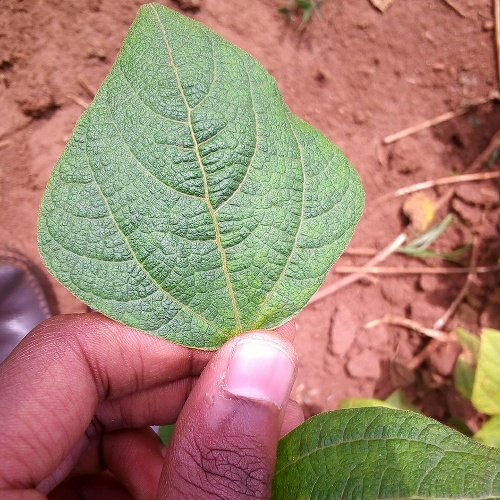

In [11]:
image

We can see that our image has been loaded correctly!

### Loading data from local folders <a class="anchor" id="datasets-local"></a>

We can also load data from local folders, in these cases we simply use an empty string (`''`) as the dataset name. 

In addition to being able to load from ImageNet style folder hierarchies, `create_dataset` also lets us extract from one or more tar archives; we can use this to avoid having to untar the archive! As an example, we can try this out on the Imagenette dataset. 

Additionally, so far we have been loading raw images, so let's also use the `transform` argument to apply some transformations; here, we can quickly create some suitable transforms using the `create_transform` function that we saw earlier!

In [15]:
from timm.data.transforms_factory import create_transform 

In [99]:
ds = create_dataset(name='', root='imagenette/imagenette2-320.tar', transform=create_transform(224))

In [100]:
image, label = ds[0]

In [101]:
image.shape

torch.Size([3, 224, 224])

By inspecting the shame of the image, we can see that our transforms have been applied.

### `ImageDataset` Class <a class="anchor" id="imagedataset"></a>

As we have seen, the `create_dataset` function offers a lot of options for handling different types of data. The reason that timm is able to offer such flexibility is by using the existing dataset classes provided in torchvision where possible, as well as providing some additional implementations - `ImageDataset` and `IterableImageDataset` which can be used in a wide range of scenarios.

Essentially, `create_dataset` simplifies this process for us by selecting an appropriate class, but sometimes we may wish to work directly with the underlying components.

The implementation that I use the most often is `ImageDataset`, which is similar to `torchvision.datasets.ImageFolder`, but with some additional functionality. Let's explore how we can use this to load our decompressed imagenette dataset.

In [ ]:
from pathlib import Path

In [21]:
from timm.data import ImageDataset

In [19]:
!ls imagenette

imagenette2-320  imagenette2-320.tar


In [102]:
imagenette_ds = ImageDataset('imagenette/imagenette2-320/train')

In [26]:
len(imagenette_ds)

9469

The key to `ImageDataset`'s flexibility is that the way it indexes and loads samples is abstracted into a `Parser` object.

Several parser are included with timm, including parsers to read images from folders, tar files and tensorflow datasets. The parser can be passed to the dataset as an argument, and we can access the parser directly.

In [27]:
imagenette_ds.parser

Here, we can see that the default parser is an instance of `ParserImageFolder`. Parsers also contain useful information such as the class lookup, which we can access as seen below.

In [28]:
imagenette_ds.parser.class_to_idx

{'n01440764': 0,
 'n02102040': 1,
 'n02979186': 2,
 'n03000684': 3,
 'n03028079': 4,
 'n03394916': 5,
 'n03417042': 6,
 'n03425413': 7,
 'n03445777': 8,
 'n03888257': 9}

We can see that this parser has converted the raw labels into integers, which can be fed to our model.

#### Selecting a parser manually - tar example

Therefore, in addition to selecting an appropriate class, `create_dataset` is also responsible for selecting the correct parser. Once again considering the compressed imagenette dataset, we can achieve the same result by manually selecting the `ParserImageInTar` parser and overriding `ImageDataset`'s default parser.

In [38]:
from timm.data.parsers.parser_image_in_tar import ParserImageInTar

data_path = 'imagenette'

ds = ImageDataset(data_path, parser=ParserImageInTar(data_path))

Inspecting the first sample, we can verify that this has loaded correctly.

In [32]:
ds[0]

(<PIL.Image.Image image mode=RGB size=426x320 at 0x7FF1B0620970>, 0)

#### Writing a custom Parser - Pets example

Unfortunately, datasets aren't always structured like ImageNet; that is, having the following structure:

    root/class_1/xx1.jpg
    root/class_1/xx2.jpg
    root/class_2/xx1.jpg
    root/class_2/xx2.jpg
   

For these datasets, `ImageDataset` won't work out of the box. Whilst we can always implement a custom Dataset to handle this, this may be challenging depending on how the data is stored. An alternative option is to write a custom parser to use with `ImageDataset`.

As an example, let's consider the pets dataset, where all images are located in a single folder, and the class name - the name of each breed in this case - is contained in the filename. 

In [39]:
!ls pets/images

Abyssinian_1.jpg		   english_cocker_spaniel_184.jpg
Abyssinian_10.jpg		   english_cocker_spaniel_185.jpg
Abyssinian_100.jpg		   english_cocker_spaniel_186.jpg
Abyssinian_100.mat		   english_cocker_spaniel_187.jpg
Abyssinian_101.jpg		   english_cocker_spaniel_188.jpg
Abyssinian_101.mat		   english_cocker_spaniel_189.jpg
Abyssinian_102.jpg		   english_cocker_spaniel_19.jpg
Abyssinian_102.mat		   english_cocker_spaniel_190.jpg
Abyssinian_103.jpg		   english_cocker_spaniel_191.jpg
Abyssinian_104.jpg		   english_cocker_spaniel_192.jpg
Abyssinian_105.jpg		   english_cocker_spaniel_193.jpg
Abyssinian_106.jpg		   english_cocker_spaniel_194.jpg
Abyssinian_107.jpg		   english_cocker_spaniel_195.jpg
Abyssinian_108.jpg		   english_cocker_spaniel_196.jpg
Abyssinian_109.jpg		   english_cocker_spaniel_197.jpg
Abyssinian_11.jpg		   english_cocker_spaniel_198.jpg
Abyssinian_110.jpg		   english_cocker_spaniel_199.jpg
Abyssinian_111.jpg		   english_cocker_spaniel_2.jpg
Abyssinian_112.jpg		   english_cock

In this case, as we are still loading images from a local file system, it is only a slight tweak on `ParserImageFolder`. Let's take a look at how that is implemented for inspiration.

timm.data.parsers.parser_image_folder.ParserImageFolder

    class ParserImageFolder(Parser):
        def __init__(self, root, class_map=""):
            super().__init__()

            self.root = root
            class_to_idx = None
            if class_map:
                class_to_idx = load_class_map(class_map, root)
            self.samples, self.class_to_idx = find_images_and_targets(
                root, class_to_idx=class_to_idx
            )
            if len(self.samples) == 0:
                raise RuntimeError(
                    f'Found 0 images in subfolders of {root}. Supported image extensions are {", ".join(IMG_EXTENSIONS)}'
                )

        def __getitem__(self, index):
            path, target = self.samples[index]
            return open(path, "rb"), target

        def __len__(self):
            return len(self.samples)

        def _filename(self, index, basename=False, absolute=False):
            filename = self.samples[index][0]
            if basename:
                filename = os.path.basename(filename)
            elif not absolute:
                filename = os.path.relpath(filename, self.root)
            return filename


From this, we can see that `ParserImageFolder` does several things:

- creates a mapping for the classes
- implements `__len__` to return the number of samples
- implements `_filename` to return the filename of the sample, with options to determine whether it whould be an absolute or relative path
- implements `__getitem__` to return the sample and target.

Now that we understand the methods that we have to implement, we can create our own implementation based on this. Here, I have used `pathlib`, from the standard library, to extract the class name and handle our paths, as I find it easier to work with than `os`.

In [57]:
from pathlib import Path

from timm.data.parsers.parser import Parser

class ParserImageName(Parser):
    def __init__(self, root, class_to_idx=None):
        super().__init__()

        self.root = Path(root)
        self.samples = list(self.root.glob("*.jpg"))

        if class_to_idx:
            self.class_to_idx = class_to_idx
        else:
            classes = sorted(
                set([self.__extract_label_from_path(p) for p in self.samples]),
                key=lambda s: s.lower(),
            )
            self.class_to_idx = {c: idx for idx, c in enumerate(classes)}

    def __extract_label_from_path(self, path):
        return "_".join(path.parts[-1].split("_")[0:-1])

    def __getitem__(self, index):
        path = self.samples[index]
        target = self.class_to_idx[self.__extract_label_from_path(path)]
        return open(path, "rb"), target

    def __len__(self):
        return len(self.samples)

    def _filename(self, index, basename=False, absolute=False):
        filename = self.samples[index][0]
        if basename:
            filename = filename.parts[-1]
        elif not absolute:
            filename = filename.absolute()
        return filename

We can now pass an instance of our parser to `ImageDataset`, which should enable it to correctly load the pets dataset!

In [67]:
data_path = Path('pets/images')
ds = ImageDataset(str(data_path), parser=ParserImageName(data_path))

Let's verify that our parser has worked by inspecting the first sample.

In [68]:
ds[0]

(<PIL.Image.Image image mode=RGB size=300x225 at 0x7FF1B0620F40>, 10)

From this, it seems that our parser has worked! Additionally, as with the default parser, we can inspect the class mapping that has been performed.

In [69]:
ds.parser.class_to_idx

{'Abyssinian': 0,
 'american_bulldog': 1,
 'american_pit_bull_terrier': 2,
 'basset_hound': 3,
 'beagle': 4,
 'Bengal': 5,
 'Birman': 6,
 'Bombay': 7,
 'boxer': 8,
 'British_Shorthair': 9,
 'chihuahua': 10,
 'Egyptian_Mau': 11,
 'english_cocker_spaniel': 12,
 'english_setter': 13,
 'german_shorthaired': 14,
 'great_pyrenees': 15,
 'havanese': 16,
 'japanese_chin': 17,
 'keeshond': 18,
 'leonberger': 19,
 'Maine_Coon': 20,
 'miniature_pinscher': 21,
 'newfoundland': 22,
 'Persian': 23,
 'pomeranian': 24,
 'pug': 25,
 'Ragdoll': 26,
 'Russian_Blue': 27,
 'saint_bernard': 28,
 'samoyed': 29,
 'scottish_terrier': 30,
 'shiba_inu': 31,
 'Siamese': 32,
 'Sphynx': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In this simple example, it would be only slightly more effort to create a custom dataset implementation. However, hopefully this helps to illustrate how easy it is to write a custom parser and make it work with `ImageDataset`!

## Optimizers <a class="anchor" id="optimizers"></a>

timm features a large number of optimizers, some of which are not available as part of PyTorch.

As well as making it easy to access familiar optimizers such as SGD, Adam and AdamW, some noteworthy inclusions are:

- `AdamP`: described [in this paper](https://arxiv.org/abs/2006.08217)
- `RMSPropTF`: an implementation of [RMSProp](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) based on the original TensorFlow implementation, with other [small tweaks discussed here](https://github.com/pytorch/pytorch/issues/23796). In my experience, this often results in more stable training than the PyTorch version
- `LAMB`:  a pure pytorch variant of [FusedLAMB optimizer from Apex](https://nvidia.github.io/apex/optimizers.html#apex.optimizers.FusedLAMB), which is TPU compatible when using PyTorch XLA
- `AdaBelief`: described [in this paper](https://arxiv.org/abs/2010.07468). Guidance on setting the hyperparameters is available [here](https://github.com/juntang-zhuang/Adabelief-Optimizer#quick-guide)
- `MADGRAD`: described [in this paper](https://arxiv.org/abs/2101.11075)
- `AdaHessian`: an adaptive second order optimizer, described [in this paper](https://arxiv.org/abs/2006.00719)

The optimizers in timm support the same interface as those in `torch.optim`, and in most cases can simply be dropped in to a training script with no changes necessary.

In [33]:
import timm.optim

To see all of the optimizers that timm implements, we can inspect the timm.optim module.

In [6]:
import inspect

import timm.optim
 
[cls_name for cls_name, cls_obj in inspect.getmembers(timm.optim) if inspect.isclass(cls_obj) if cls_name !='Lookahead']


['AdaBelief',
 'Adafactor',
 'Adahessian',
 'AdamP',
 'AdamW',
 'Lamb',
 'Lars',
 'MADGRAD',
 'Nadam',
 'NvNovoGrad',
 'RAdam',
 'RMSpropTF',
 'SGDP']

The easiest way to create an optimizer is by using the `create_optimizer_v2` factory function, which expects the following:
- a model, or set of parameters
- the name of the optimizer
- any arguments to pass to the optimizer


We can use this function to create any of the optimizer implementations included from timm, as well as popular optimizers from torch.optim and the [fused optimizers](https://nvidia.github.io/apex/optimizers.html) from [Apex](https://nvidia.github.io/apex/index.html) (if installed). 

Let's take a look at some examples.

In [8]:
import torch

In [9]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
    torch.nn.Flatten(0, 1)
)

In [20]:
optimizer = timm.optim.create_optimizer_v2(model, opt='sgd', lr=0.01, momentum=0.8); optimizer, type(optimizer)

(SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     momentum: 0.8
     nesterov: True
     weight_decay: 0.0
 ),
 torch.optim.sgd.SGD)

Here, we can see that as timm does not contain an implementation of SGD, it has created our optimizer using the implementation from `torch.optim`.

Let's try creating one of the optimizers implemented in timm.

In [34]:
optimizer = timm.optim.create_optimizer_v2(model, 
                                           opt='lamb',
                                           lr=0.01,
                                           weight_decay=0.01)

In [35]:
optimizer, type(optimizer)

(Lamb (
 Parameter Group 0
     always_adapt: False
     betas: (0.9, 0.999)
     bias_correction: True
     eps: 1e-06
     grad_averaging: True
     lr: 0.01
     max_grad_norm: 1.0
     trust_clip: False
     weight_decay: 0.0
 
 Parameter Group 1
     always_adapt: False
     betas: (0.9, 0.999)
     bias_correction: True
     eps: 1e-06
     grad_averaging: True
     lr: 0.01
     max_grad_norm: 1.0
     trust_clip: False
     weight_decay: 0.01
 ),
 timm.optim.lamb.Lamb)

We can verify that timm's implementation of `Lamb` has been used, and our weight decay has been applied to parameter group 1.

### Creating optimizers manually

Of course, if we prefer not to use `create_optimizer_v2`, all of these optimizers can be created in the usual way.

In [21]:
optimizer = timm.optim.RMSpropTF(model.parameters(), lr=0.01)

### Usage Example <a class="anchor" id="optimizer-usage"></a>

Now, we can use most of these optimizers as demonstrated below:

```
# replace 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# with
optimizer = timm.optim.AdamP(model.parameters(), lr=0.01)

for epoch in num_epochs:
    for batch in training_dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
```
           

At the time of writing, the only exception to this is the second order `Adahessian` optimizer, which requires a small tweak when performing the `backward` step; similar tweaks are likely to be needed for additional second order optimizers which may be added in future.

This is demonstrated below.

```

optimizer = timm.optim.Adahessian(model.parameters(), lr=0.01)

is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order # True

for epoch in num_epochs:
    for batch in training_dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        loss.backward(create_graph=second_order)
        optimizer.step()
        optimizer.zero_grad()
            
```
           

### Lookahead <a class="anchor" id="lookahead"></a>

timm also enables us to apply the lookahead algorithm to an optimizer; introduced [here](https://arxiv.org/abs/1907.08610) and explained excellently [here](https://www.youtube.com/watch?v=TxGxiDK0Ccc). Lookahead may improve the learning stability and lowers the variance of its inner optimizer, with negligible computation and memory cost.

We can apply Lookahead to an optimizer by prefixing the optimizer name with `lookahead_`

In [81]:
optimizer = timm.optim.create_optimizer_v2(model.parameters(), opt='lookahead_adam', lr=0.01)

or wrapping by the optimizer instance in timm's Lookahead class

In [ ]:
timm.optim.Lookahead(optimizer, alpha=0.5, k=6)

When using Lookahead, we need to update our training script to include the following line, to update the slow weights.

In [ ]:
optimizer.sync_lookahead()

An example of how this can be used is demonstrated below

```
optimizer = timm.optim.AdamP(model.parameters(), lr=0.01)
optimizer = timm.optim.Lookahead(optimizer)

for epoch in num_epochs:
    for batch in training_dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    optimizer.sync_lookahead()
    
            
```
           

## Schedulers <a class="anchor" id="schedulers"></a>

At the time of writing, timm contains the following schedulers:

- `StepLRScheduler`: the learning rate decays every _n_ steps; similar to `torch.optim.lr_scheduler.StepLR`
- `MultiStepLRScheduler`: a step scheduler that supports multiple milestones at which to reduce the learning rate; similar to `torch.optim.lr_scheduler.MultiStepLR`
- `PlateauLRScheduler`: reduces the learning rate by a specified factor each time a specified metric plateaus; similar to `torch.optim.lr_scheduler.ReduceLROnPlateau`
- `CosineLRScheduler`: cosine decay schedule with restarts, as described in [this paper](https://arxiv.org/abs/1608.03983); similar to `torch.optim.lr_scheduler.CosineAnnealingWarmRestarts`
- `TanhLRScheduler`: hyberbolic-tangent decay schedule with restarts, as described in [this paper](https://arxiv.org/abs/1806.01593)
- `PolyLRScheduler`: polynomial decay schedule, as described in [this paper](https://arxiv.org/abs/2004.05909)

Whilst many of the schedulers implemented in timm have counterparts in PyTorch, the timm versions often have different default hyperparameters as well as providing additional options and flexibility; all timm schedulers support warmup epochs, as well as having the option to add random noise to the schedule. Additionally, the `CosineLRScheduler` and `PolyLRScheduler` support a decay option known as _k-decay_ as introduced [here](https://arxiv.org/abs/2004.05909).

Let's first explore how we can use a scheduler from timm in a custom training script, before examining some of the options that these schedulers provide.

### Usage example <a class="anchor" id="scheduler-usage"></a>

Unlike the the schedulers included in PyTorch, it is good practice to update timm schedulers twice per epoch:

- the `.step_update` method should be called **after each optimizer update**, with the index of the next update; this where we would call `.step` for a PyTorch scheduler
- the `.step` method should be called **at the end of each epoch**, with the index of the next epoch

By explicitly providing the number of updates and the epoch indices, this enables the timm schedulers to remove the confusing `last_epoch` and `-1` behaviour observed in PyTorch schedulers.

An example of how we can use a timm scheduler is presented below:

```
training_epochs = 300
cooldown_epochs = 10
num_epochs = training_epochs + cooldown_epochs

optimizer = timm.optim.AdamP(my_model.parameters(), lr=0.01)
scheduler = timm.scheduler.CosineLRScheduler(optimizer, t_initial=training_epochs)

for epoch in range(num_epochs):

    num_steps_per_epoch = len(train_dataloader)
    num_updates = epoch * num_steps_per_epoch

    for batch in training_dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        loss.backward()
        optimizer.step()
        scheduler.step_update(num_updates=num_updates)

        optimizer.zero_grad()

    scheduler.step(epoch + 1)
            
```
           

### Adjusting Learning rate schedules <a class="anchor" id="lr-cycles"></a>

To demonstrate some of the options that timm offers, let's explore some of the hyperparameters which are available, and how modifying these affects on the learning rate schedule.

Here, we shall focus on the `CosineLRScheduler`, as this is the scheduler used by default in timm's training scripts. However, as described above, features such as adding warmup and noise are present in all of the schedulers listed above.

So that we can visualise the learning rate schedule, let's define a function to create a model and optimizer to use with our scheduler. Note that, as we will only be updating the scheduler, the model is not actually being optimized, but we require an optimizer instance to work with our scheduler, and an optimizer requires a model.

In [2]:
def create_model_and_optimizer():
    model = torch.nn.Linear(2, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    return model, optimizer

#### Using the `CosineAnnealingWarmRestarts` scheduler from PyTorch

To illustrate timm's cosine scheduler differs from the one included in PyTorch, let's first look at how we would use the torch implementation of `CosineAnnealingWarmRestarts`. 

This class supports the following parameters:

- `T_0` (_int_): Number of iterations for the first restart. 
- `T_mult` (_int_): A factor that increases `T_{i}` after a restart. (Default: `1`)
- `eta_min` (_float_): Minimum learning rate. (Default: `0.`)
- `last_epoch` (_int_) – The index of last epoch. (Default: `-1`)

To set our schedule, we need to define the following: the number of epochs, the number of updates that take place per epoch, and - if we would like to enable restarts - the number of steps at which the learning rate should return to its initial value. As we are not using any data here, we can set these somewhat arbitrarily.

In [3]:
num_epochs=300
num_epoch_repeat = num_epochs//2
num_steps_per_epoch = 10

**Note**: Here, we have specified that we would like the learning rate to 'restart' halfway through the training run. This was selected primarily for visualisation purposes - so that we can understand what a restart looks like for this scheduler - as opposed to this being the recommended way to use this scheduler during a real training run. 

Now, let's create our learning rate scheduler. As `T_0` requires the time until the first restart to be specified in terms of the number of iterations - where each iteration is a batch - we calculate this by multiplying the index of the epoch that we would like the restart to occur with the number of steps per epoch. Here, we are also specifying that the learning rate should never drop below `1e-6`.

In [4]:
model, optimizer = create_model_and_optimizer()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                T_0=num_epoch_repeat*num_steps_per_epoch,
                                                                T_mult=1,
                                                                eta_min=1e-6,
                                                                last_epoch=-1)

Now, we can simulate using this scheduler in a training loop. As we are using the PyTorch implementation, we only need to call `step` after each optimizer update, which is once per batch. Here, we are recording the value of the learning rate after each step, so that we can visualise how the value of the learning rate was adjusted over the whole training run.

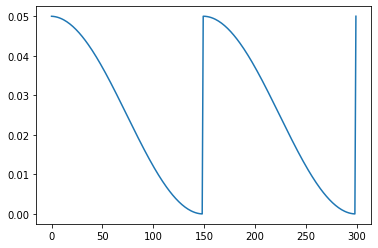

In [30]:
import matplotlib.pyplot as plt

lrs = []

for epoch in range(num_epochs):

    for i in range(num_steps_per_epoch):
        scheduler.step()
        
    lrs.append(
        optimizer.param_groups[0]["lr"]
    )

plt.plot(lrs)

From this plot, we can see that the learning rate decayed until epoch 150, at which it was reset to its initial value before decaying again; just as we expected.

#### Using the `CosineLRScheduler` scheduler from timm

In [4]:
import timm.scheduler

Now that we understand how to use PyTorch's cosine scheduler, let's explore how this compares with the implementation included in timm, and the additional options that are offered. To begin, let's replicate the previous plot using timm's implementation of a cosine learning rate scheduler - `CosineLRScheduler`.

Some of arguments that we will need to do this are similar to those that we have seen before:
- `t_initial` (_int_): Number of iterations for the first restart, this is equivalent to `T_0` in torch's implementation
- `lr_min` (_float_): Minimum learning rate, this is equivalent to `eta_min` in torch's implementation (Default: `0.`)
- `cycle_mul` (_float_): A factor that increases `T_{i}` after a restart, this is equivalent to `T_mult` in torch's implementation (Default: `1`)

However, to observe behaviour consistent with Torch, we will also need to set:
- `cycle_limit` (_int_): Limit the number of restarts in a cycle (Default: `1`)
- `t_in_epochs` (_bool_): Whether the number iterations is given in terms of epochs rather than the number of batch updates (Default: `True`)

First, let's define the same schedule as before.

In [10]:
num_epochs=300
num_epoch_repeat = num_epochs/2
num_steps_per_epoch = 10

Now, we can create our scheduler instance. Here, we are expressing the number of iterations in terms of the number of update steps, and increasing the cycle limit to more than our desired number of restarts; so that the parameters are the same as we used with torch's implementation earlier.

In [15]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat*num_steps_per_epoch,
                                            lr_min=1e-6,
                                            cycle_limit=num_epoch_repeat+1,
                                            t_in_epochs=False)


Now, let's define a new function to simulate using a timm scheduler in a training run and record the updates to the learning rate.

In [6]:

def plot_lrs_for_timm_scheduler(scheduler):
    lrs = []

    for epoch in range(num_epochs):
        num_updates = epoch * num_steps_per_epoch

        for i in range(num_steps_per_epoch):
            num_updates += 1
            scheduler.step_update(num_updates=num_updates)

        scheduler.step(epoch + 1)

        lrs.append(optimizer.param_groups[0]["lr"])

    plt.plot(lrs)


We can now use this to plot our learning rate schedule!

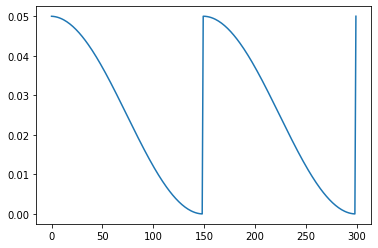

In [17]:
plot_lrs_for_timm_scheduler(scheduler)

As expected, our graph looks identical to the one we saw earlier.

Now that we have replicated the behaviour that we saw in torch, let's look at some of the additional features that timm offers in more detail.

Until now, we have expressed the number of iterations in terms of optimizer updates; which required us to calculate the number of iterations for the first repeat using `num_epoch_repeat * num_steps_per_epoch`. However, by specifying our iterations in terms of epochs - which is the default in timm - we can avoid having to do this calculation. Using the default setting, we can simply pass the index of the epoch at which we would like the first restart to occur, as demonstrated below.

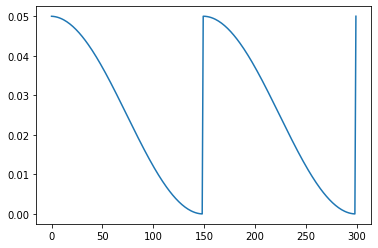

In [33]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat, 
                                            lr_min=1e-6,
                                            t_in_epochs=True, 
                                            cycle_limit=num_epoch_repeat+1)

plot_lrs_for_timm_scheduler(scheduler)

We can see that our schedule is unchanged, we have just expressed our arguments slightly differently.

#### Adding Warm up and Noise

Another feature of all timm optimizers, is that they support adding warm up and noise to a learning rate schedule. We can specify the number of warm up epochs, and the initial learning rate to be used during the warm up, with the `warmup_t` and `warmup_lr_init` arguments. Let's see how our schedule changes if we specify that we would like 20 warm up epochs.

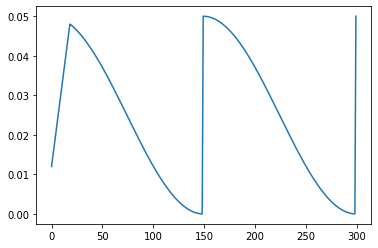

In [34]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            warmup_lr_init=0.01,
                                            warmup_t=20,
                                            cycle_limit=num_epoch_repeat+1
                                           )
plot_lrs_for_timm_scheduler(scheduler)

Here, we can see that this has resulted in a more gradual increase to our minimum learning rate, rather than starting at that point as we saw before.

We can also add noise to a range of epochs, using the `noise_range_t` and `noise_pct` arguments. Let's add a small amount of noise to the first 150 epochs:

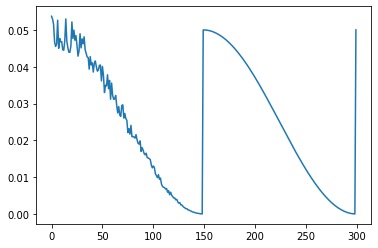

In [35]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            noise_range_t=(0, 150),
                                            noise_pct=0.1,
                                            cycle_limit=num_epoch_repeat+1
                                           )

plot_lrs_for_timm_scheduler(scheduler)

We can see that, up until epoch 150, the added noise affects our schedule so that learning rate does not decrease in a smooth curve. We can make this more extreme by increasing `noise_pct`.

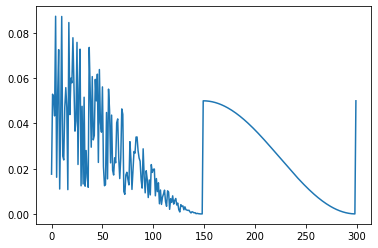

In [36]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            noise_range_t=(0, 150),
                                            noise_pct=0.8,
                                            cycle_limit=num_epoch_repeat+1
                                           )

plot_lrs_for_timm_scheduler(scheduler)

#### Additional options for `CosineLRScheduler`

Whilst warm up and noise can be used with any scheduler, there are some additional features which are specific to `CosineLRScheduler`. Let's explore how these affect our learning rate cycle. 

We can use `cycle_mul`, to increase the time until the next restart, as seen below.

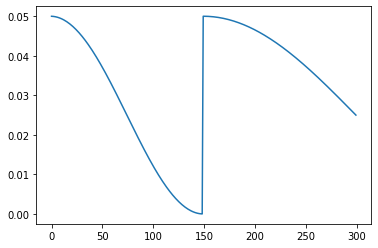

In [37]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat*num_steps_per_epoch,
                                            cycle_limit=num_epoch_repeat+1,
                                            cycle_mul=2.,
                                            t_in_epochs=False)
plot_lrs_for_timm_scheduler(scheduler)

Additionally, timm provides the option to limit the number of restarts with `cycle_limit`. By default, this is set to `1`, which results in the following schedule.

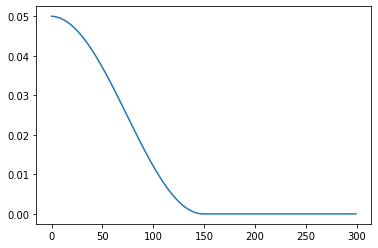

In [38]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat, 
                                            lr_min=1e-5,
                                            cycle_limit=1)


plot_lrs_for_timm_scheduler(scheduler)

`CosineLRScheduler` also supports different types of decay. We can use `cycle_decay` to reduce (or increase) the value of the learning rate that will be set during each successive restart. 

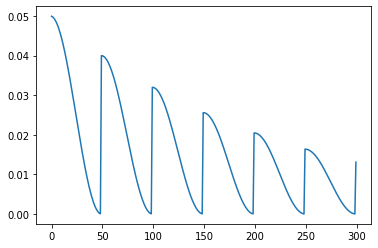

In [39]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=50, 
                                            lr_min=1e-5,
                                            cycle_decay=0.8,
                                            cycle_limit=num_epoch_repeat+1
                                           )
plot_lrs_for_timm_scheduler(scheduler)

**Note**: here we have increased the frequency of the number of restarts to better illustrate the decay.

To control the curve itself, we can use the `k_decay` argument, for which the rate of change of the learning rate is changed by its k-th order derivative, as explained in [this paper](https://arxiv.org/abs/2004.05909).

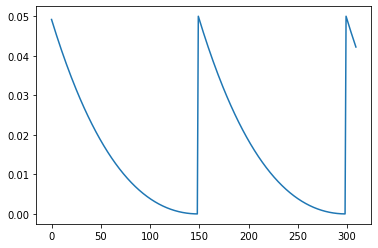

In [46]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat, 
                                            lr_min=1e-5,
                                            k_decay=0.5,
                                            cycle_limit=num_epoch_repeat+1
                                           )
plot_lrs_for_timm_scheduler(scheduler)

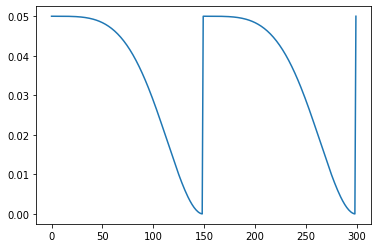

In [40]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat, 
                                            lr_min=1e-5,
                                            k_decay=2,
                                            cycle_limit=num_epoch_repeat+1
                                           )
plot_lrs_for_timm_scheduler(scheduler)

This option provides even more control over the annealing performed by this scheduler!

#### Default settings in timm's training script

If we set this scheduler using the default settings from timm's training script, we observe the following schedule. 

**Note**: in the training script, training continues for an additional 10 epochs without further modifications to the learning rate as a 'cool down'.

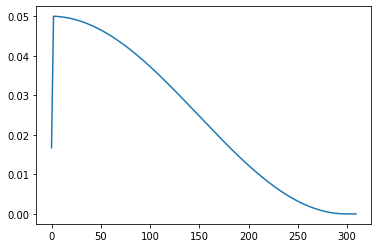

In [41]:
model, optimizer = create_model_and_optimizer()

training_epochs=300
cooldown_epochs=10
num_epochs = training_epochs + cooldown_epochs
num_steps_per_epoch = 10

lr_sched = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=training_epochs,
                                            cycle_decay=0.5,
                                            lr_min=1e-6,
                                            t_in_epochs=True,
                                            warmup_t=3,
                                            warmup_lr_init=1e-4,
                                            cycle_limit=1,
                                           )

plot_lrs_for_timm_scheduler(lr_sched)

As we can see, there are no restarts at all with the default settings!

### Other Learning rate schedulers

Whilst my favourite of the schedulers included with timm is `CosineLRScheduler`, it may be helpful to visualise the schedules of some of the other schedulers, that have no counterpart in PyTorch. Both of these schedulers are similar to the cosine scheduler in the sense that the learning rate is reset after a specified number epochs - assuming a cycle limit is not set - but the annealing is done slightly differently.

For the `TanhLRScheduler`, annealing is performed using the hyperbolic-tangent function, as demonstrated below.

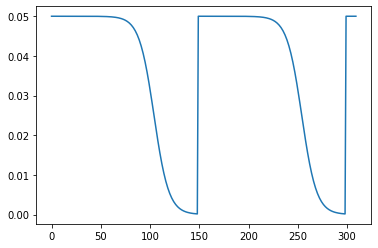

In [42]:
model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.TanhLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            cycle_limit=num_epoch_repeat+1,
                                           )
plot_lrs_for_timm_scheduler(scheduler)

timm also provides `PolyLRScheduler`, which uses a polynomial decay:

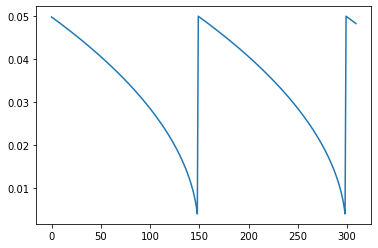

In [43]:
model, optimizer = create_model_and_optimizer()

lr_sched = timm.scheduler.PolyLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            cycle_limit=num_epoch_repeat+1,
                                           )
plot_lrs_for_timm_scheduler(lr_sched)

Similarly to `CosineLRScheduler`, the `PolyLRScheduler` scheduler also supports the `k_decay` argument, as demonstrated below:

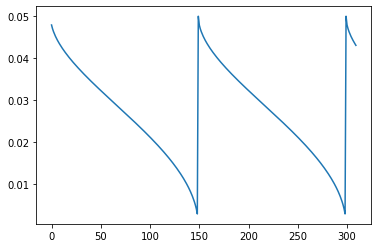

In [47]:
model, optimizer = create_model_and_optimizer()

lr_sched = timm.scheduler.PolyLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            cycle_limit=num_epoch_repeat+1,
                                            k_decay=0.5
                                           )
plot_lrs_for_timm_scheduler(lr_sched)

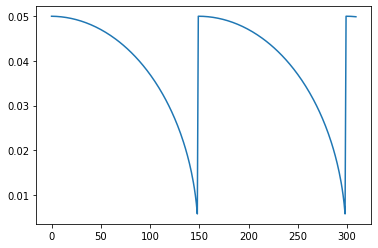

In [48]:
model, optimizer = create_model_and_optimizer()

lr_sched = timm.scheduler.PolyLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat,
                                            lr_min=1e-5,
                                            cycle_limit=num_epoch_repeat+1,
                                            k_decay=2
                                           )
plot_lrs_for_timm_scheduler(lr_sched)

## Exponential Moving Average Model <a class="anchor" id="ema-model"></a>

When training a model, it can be beneficial to set the values for the model weights by taking a moving average of the parameters that were observed across the entire training run, as opposed to using the parameters obtained after the last incremental update. In practice, this is often done by maintaining an *EMA model*, which is a copy of the model that we are training. However, rather than updating all of the parameters of this model after every update step, we set these parameters using a linear combination of the existing parameter values and the updated values. This is done using the following formula:

*updated_EMA_model_weights* =  _decay_ * _EMA_model_weights_ + (1. - _decay_) * _updated_model_weights_

where the _decay_ is a parameter that we set. For example, if we set `decay=0.99`, we have:

*updated_EMA_model_weights* =  0.99 * _EMA_model_weights_ + 0.01 * _updated_model_weights_

which we can see is keeping 99% of the existing state and only 1% of the new state! 

To understand why this may be beneficial, let's consider the case that our model, in an early stage of training, performs exceptionally poorly on a batch of data. This may result in a large update update to our parameters, overcompensating for the high loss obtained, which will be detrimental for the upcoming batches. By only incorporating only a small percentage of the latest parameters, large updates will be 'smoothed', and have less of an overall impact on the model's weights.

Sometimes, these averaged parameters can sometimes produce significantly better results during evaluation, and this technique has been employed in several training schemes for popular models such as training MNASNet, MobileNet-V3 and EfficientNet; using the [implementation included in TensorFlow](https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage). Using the `ModelEmaV2` module implemented in timm, we can replicate this behaviour, and apply the same practice to our own training scripts.

The implementation of `ModelEmaV2` expects the following arguments:

- `model`: the subclass of `nn.Module` that we are training. This is the model that will be updated in our training loop as normal
-`decay` (_float_): the amount of decay to use, which determines how much of the previous state will be maintained. The Tensorflow documentation suggests that reasonable values for decay are close to 1.0, typically in the multiple-nines range: 0.999, 0.9999, etc. (Default: `0.9999`)
- `device`: the device that should be used to evaluate the EMA model. If this is not set, the EMA model will be created on the same device that is being used for the model.

Let's explore how we can incorporate this in a training loop.

### Usage example

```
model = create_model().to(gpu_device)
ema_model = ModelEmaV2(model, decay=0.9998)

for epoch in num_epochs:
    for batch in training_dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        model_ema.update(model)
    
    for batch in validation_dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        validation_loss = loss_function(outputs, targets)
        
        ema_model_outputs = model_ema.module(inputs)
        ema_model_validation_loss = loss_function(ema_model_outputs, targets) 
            
```
           

As we can see, to update the parameters of the EMA model, we need to call `.update` after each parameter update. As the EMA model has different parameters to the one being trained, we must evaluate this separately.

It is important to note that this class is sensitive to where it is initialised. During distributed training, it should be applied before before the conversion to SyncBatchNorm takes place and before the DistributedDataParallel wrapper is used!

Additionally, when saving the EMA model, the keys inside the `state_dict` will be the same as those for the model being trained, so a different checkpoint should be used! 

## Putting it all together <a class="anchor" id="example"></a>

Whilst the pseudocode snippets throughout this article illustrate how each component can be used in a training loop individually, let's explore an example where we use many different components at once!

Here, we shall look at training a model on Imagenette. Note that, as Imagenette is a subset of Imagenet, if we use a pretrained model we are cheating slightly, as only the new classification head will be initialised with random weights; therefore, in this example, we shall train from scratch. 

Note: The purpose of this example is to demonstrate how multiple components from timm can be used together. As such, the features selected - and the hyperparameters used - have been selected somewhat arbitrarily; so the performance could probably be improved with some careful tuning!

To remove the boilerplate that we usually see in PyTorch training loops, such as iterating through the DataLoaders and moving data between devices, we shall use PyTorch-accelerated to handle our training; this enables us to focus only on the differences that are required when using timm components.

If you are unfamiliar with PyTorch-accelerated and would like to learn more about it before diving into this article, please check out [the introductory blog post](https://towardsdatascience.com/introducing-pytorch-accelerated-6ba99530608c?source=friends_link&sk=868c2d2ec5229fdea42877c0bf82b968) or [the docs](https://pytorch-accelerated.readthedocs.io/en/latest/index.html); alternatively, it's very simple and a lack of knowledge in this area should not impair your understanding of the content explored here!

In PyTorch-accelerated, the training loop is handled by the `Trainer` class; where we can override specific methods to change the behaviour at certain steps. In pseudocode, the execution of a training run inside of the PyTorch-accelerated Trainer can be depicted as:

    train_dl = create_train_dataloader()
    eval_dl = create_eval_dataloader()
    scheduler = create_scheduler()

    training_run_start()
    on_training_run_start()

    for epoch in num_epochs:
        train_epoch_start()
        on_train_epoch_start()
        for batch in train_dl:
            on_train_step_start()
            batch_output = calculate_train_batch_loss(batch)
            on_train_step_end(batch, batch_output)
            backward_step(batch_output["loss"])
            optimizer_step()
            scheduler_step()
            optimizer_zero_grad()
        train_epoch_end()
        on_train_epoch_end()

        eval_epoch_start()
        on_eval_epoch_start()
        for batch in eval_dl:
            on_eval_step_start()
            batch_output = calculate_eval_batch_loss(batch)
            on_eval_step_end(batch, batch_output)
        eval_epoch_end()
        on_eval_epoch_end()

        training_run_epoch_end()
        on_training_run_epoch_end()

    training_run_end()
    on_training_run_end()

More details about how the Trainer works can be found in the documentation. We can subclass the default trainer, and use this in a training script, as demonstrated below:

In [ ]:
%%writefile train.py

import argparse
from pathlib import Path

import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
import torchmetrics
from timm.scheduler import CosineLRScheduler

from pytorch_accelerated.callbacks import SaveBestModelCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS


def create_datasets(image_size, data_mean, data_std, train_path, val_path):
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )

    train_dataset = timm.data.dataset.ImageDataset(
        train_path, transform=train_transforms
    )
    eval_dataset = timm.data.dataset.ImageDataset(val_path, transform=eval_transforms)

    return train_dataset, eval_dataset


class TimmMixupTrainer(Trainer):
    def __init__(self, eval_loss_fn, mixup_args, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        self.num_updates = None
        self.mixup_fn = timm.data.Mixup(**mixup_args)

        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes)
        self.ema_accuracy = torchmetrics.Accuracy(num_classes=num_classes)
        self.ema_model = None

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1,
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9
        )
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch):
        xb, yb = batch
        mixup_xb, mixup_yb = self.mixup_fn(xb, yb)
        return super().calculate_train_batch_loss((mixup_xb, mixup_yb))

    def train_epoch_end(
        self,
    ):
        self.ema_model.update(self.model)
        self.ema_model.eval()

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)
            val_loss = self.eval_loss_fn(outputs, yb)
            self.accuracy.update(outputs.argmax(-1), yb)

            ema_model_preds = self.ema_model.module(xb).argmax(-1)
            self.ema_accuracy.update(ema_model_preds, yb)

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric(
            "ema_model_accuracy", self.ema_accuracy.compute().cpu()
        )
        self.accuracy.reset()
        self.ema_accuracy.reset()


def main(data_path):

    # Set training arguments, hardcoded here for clarity
    image_size = (224, 224)
    lr = 5e-3
    smoothing = 0.1
    mixup = 0.2
    cutmix = 1.0
    batch_size = 32
    bce_target_thresh = 0.2
    num_epochs = 40

    data_path = Path(data_path)
    train_path = data_path / "train"
    val_path = data_path / "val"
    num_classes = len(list(train_path.iterdir()))

    mixup_args = dict(
        mixup_alpha=mixup,
        cutmix_alpha=cutmix,
        label_smoothing=smoothing,
        num_classes=num_classes,
    )

    # Create model using timm
    model = timm.create_model(
        "resnet50d", pretrained=False, num_classes=num_classes, drop_path_rate=0.05
    )

    # Load data config associated with the model to use in data augmentation pipeline
    data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
    data_mean = data_config["mean"]
    data_std = data_config["std"]

    # Create training and validation datasets
    train_dataset, eval_dataset = create_datasets(
        train_path=train_path,
        val_path=val_path,
        image_size=image_size,
        data_mean=data_mean,
        data_std=data_std,
    )

    # Create optimizer
    optimizer = timm.optim.create_optimizer_v2(
        model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
    )

    # As we are using Mixup, we can use BCE during training and CE for evaluation
    train_loss_fn = timm.loss.BinaryCrossEntropy(
        target_threshold=bce_target_thresh, smoothing=smoothing
    )
    validate_loss_fn = torch.nn.CrossEntropyLoss()

    # Create trainer and start training
    trainer = TimmMixupTrainer(
        model=model,
        optimizer=optimizer,
        loss_func=train_loss_fn,
        eval_loss_fn=validate_loss_fn,
        mixup_args=mixup_args,
        num_classes=num_classes,
        callbacks=[
            *DEFAULT_CALLBACKS,
            SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
        ],
    )

    trainer.train(
        per_device_batch_size=batch_size,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        num_epochs=num_epochs,
        create_scheduler_fn=trainer.create_scheduler,
    )


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Simple example of training script using timm.")
    parser.add_argument("--data_dir", required=True, help="The data folder on disk.")
    args = parser.parse_args()
    main(args.data_dir)

Now, lets create a config file for our training run

In [ ]:
%%writefile accelerate_config.py
compute_environment: LOCAL_MACHINE
deepspeed_config: {}
distributed_type: MULTI_GPU
fp16: true
machine_rank: 0
main_process_ip: null
main_process_port: null
main_training_function: main
num_machines: 1
num_processes: 1


We can now launch our training using the following command

In [ ]:
!accelerate launch --config_file accelerate_config.yaml train.py --data_dir imagenette/imagenette2-320

Using this training script on Imagenette using 2 GPUs, [following the instructions here](https://pytorch-accelerated.readthedocs.io/en/latest/quickstart.html), I obtained the following metrics:
- accuracy: 0.89
- ema_model_accuracy: 0.85

after 34 epochs; which isn't bad considering that the hyperparameters haven't been tuned!

# Conclusion

Hopefully that has provided a somewhat comprehensive overview of some of the features included in timm, and how these can be applied in custom training scripts.

Finally, I'd like to take a moment to acknowledge the sheer amount of effort that has been put into creating this awesome library by Ross Wightman, the creator of timm. Ross's dedication to providing implementations of state-of-the-art computer vision models that are easily accessible to the whole data science community is second to none. If you haven't already, go and add stars!